In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)
path+="/kc_house_data.csv"

Path to dataset files: /home/panda/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1


In [ ]:
import pandas as pd

# Đọc file
df = pd.read_csv(path)

# Làm sạch cơ bản
df['date'] = pd.to_datetime(df['date'])
df = df.dropna() #  Loại bỏ tất cả các hàng trong DataFrame có chứa giá trị bị thiếu (NaN, NaT, None).
df = df[df['price'] > 0]

df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
print(df['bedrooms'].unique())

[ 3  2  4  5  1  6  7  0  8  9 11 10 33]


<Axes: xlabel='bedrooms'>

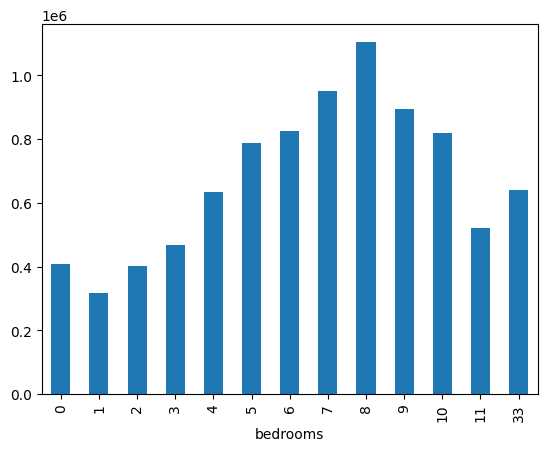

In [7]:
import matplotlib.pyplot as plt

df.groupby('bedrooms')['price'].mean().plot(kind='bar')


In [13]:
print(df['bedrooms'].unique())

[ 3  2  4  5  1  6  7  0  8  9 11 10 33]


In [ ]:
import os

# Lưu tạm vào local
local_path = "../data/cleaned_data_for_hdfs.csv"
df.to_csv(local_path, index=False)

# Copy lên HDFS (giả sử HDFS đang chạy ở localhost)
hdfs_path = "/DataEngineer/housing_data"
os.system(f"hdfs dfs -mkdir -p /DataEngineer/housing_data")
os.system(f"hdfs dfs -put -f {local_path} {hdfs_path}") # 🔁 -put -f: Ghi đè nếu file đã tồn tại.

print("✅ Đã lưu dữ liệu lên HDFS:", hdfs_path)


✅ Đã lưu dữ liệu lên HDFS: /DataEngineer/housing_data


In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HousingAnalysis").getOrCreate()
df = spark.read.csv("hdfs:///DataEngineer/housing_data/cleaned_data_for_hdfs.csv", header=True, inferSchema=True)

df.groupBy("bedrooms").avg("price").show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+--------+------------------+
|bedrooms|        avg(price)|
+--------+------------------+
|       1|317642.88442211057|
|       6| 825520.6360294118|
|       3|466232.07848127035|
|       5| 786599.8288569644|
|       9| 893999.8333333334|
|       4| 635419.5042138913|
|       8| 1105076.923076923|
|       7| 951184.6578947369|
|      10| 819333.3333333334|
|      11|          520000.0|
|      33|          640000.0|
|       2|  401372.681884058|
|       0| 409503.8461538461|
+--------+------------------+

